In [1]:
import pandas as pd
import spacy
import nltk
import re
import unidecode
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import warnings
import os

In [2]:
df = pd.read_parquet(r"D:\Python for Data Analysis\alerj\leis-ordinarias\todos\leis_ordinarias.parquet")

In [3]:
#criar uma coluna data_proposicao ao reconhecer na coluna tramitacao o texto "[Data: mm/dd/yyyy]"
df['data_proposicao'] = df['tramitacao'].str.extract(r'\[Data:\s*(\d{2}/\d{2}/\d{4})\]').squeeze()
df['data_proposicao'] = pd.to_datetime(df['data_proposicao'], format='%m/%d/%Y', errors='coerce')

#criar coluna legislação
#se 2011 <= ano <= 2014 em data_proposicao -> Legislação 2011-2015
#se 2015 <= ano <= 2018 em data_proposicao -> Legislação 2015-2019
#se 2019 <= ano <= 2022 em data_proposicao -> Legislação 2019-2023
def classify_legislation(date):
    if pd.isna(date):
        return 'Desconhecido'
    year = date.year
    if 2011 <= year <= 2014:
        return 'Legislação 2011-2015'
    elif 2015 <= year <= 2018:
        return 'Legislação 2015-2019'
    elif 2019 <= year <= 2022:
        return 'Legislação 2019-2023'
    else:
        return 'Fora do intervalo'
df['legislacao'] = df['data_proposicao'].apply(classify_legislation)
df[['data_proposicao', 'legislacao']].head(10)

,data_proposicao,legislacao
0,2011-02-04,Legislação 2011-2015
1,2011-02-04,Legislação 2011-2015
2,2011-02-04,Legislação 2011-2015
3,2011-02-04,Legislação 2011-2015
4,2011-02-04,Legislação 2011-2015
5,2011-02-04,Legislação 2011-2015
6,2011-02-04,Legislação 2011-2015
7,2011-02-04,Legislação 2011-2015
8,2011-02-04,Legislação 2011-2015
9,2011-02-04,Legislação 2011-2015


<>:144: SyntaxWarning: invalid escape sequence '\T'
<>:144: SyntaxWarning: invalid escape sequence '\T'
C:\Users\jonas\AppData\Local\Temp\ipykernel_24104\3043443771.py:144: SyntaxWarning: invalid escape sequence '\T'
  print(f"\Total de leis: {len(df)}")


ANÁLISE TEMPORAL: LEGISLAÇÃO SOBRE CRIMINALIDADE E VIOLÊNCIA
ALERJ - Leis Ordinárias 2011-2024
\Total de leis: 14416
Período: 2011 - 2022

Processando análise semântica...
1. ANÁLISE POR LEGISLATURA

Comparação por Legislatura:
Legislação 2011-2015      | Total: 3296 | Criminalidade: 243 |  7.37%
Legislação 2015-2019      | Total: 4584 | Criminalidade: 505 | 11.02%
Legislação 2019-2023      | Total: 6536 | Criminalidade: 819 | 12.53%

Variação entre legislaturas:
   2011-2015 → 2015-2019: +3.64 pontos percentuais
   2015-2019 → 2019-2023: +1.51 pontos percentuais
   2011-2015 → 2019-2023: +5.16 pontos percentuais


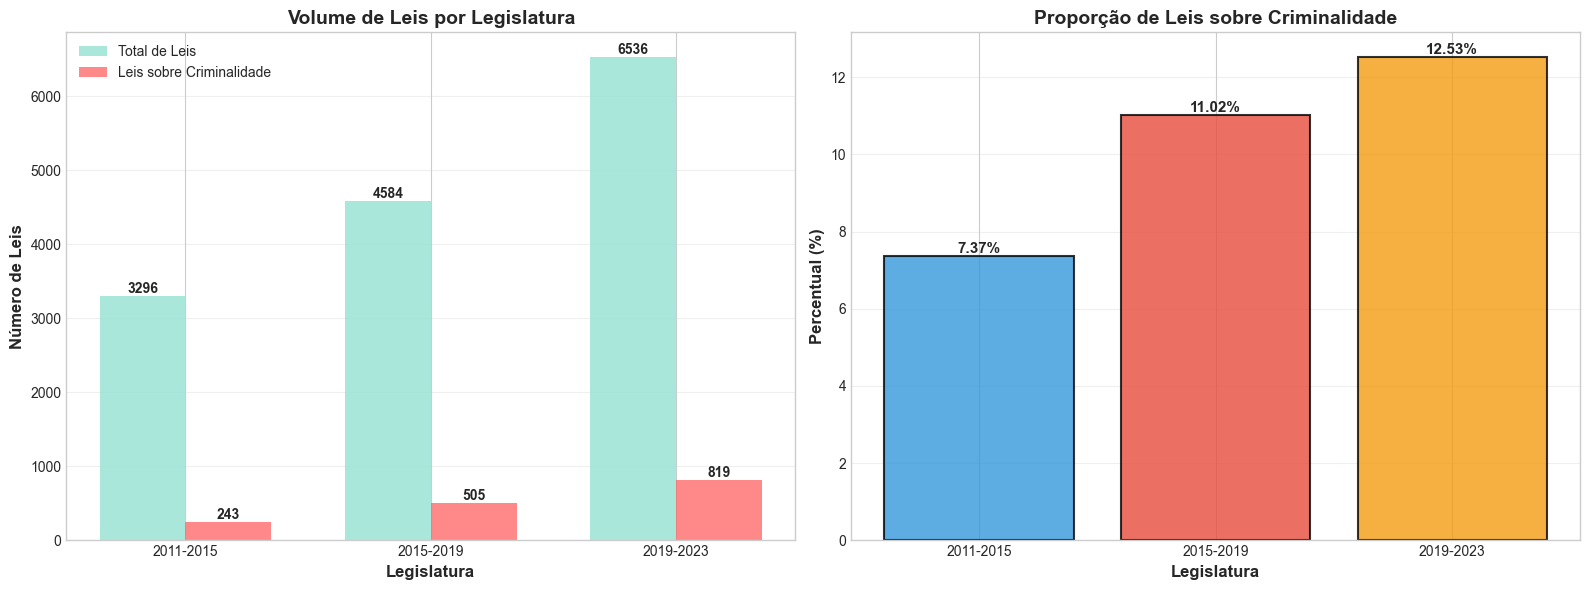

2. ANÁLISE POR ANO - FOCO EM ANOS ELEITORAIS

Análise Ano a Ano:
2011 | Total: 1183 | Criminalidade:  78 |  6.59%
2012 | Total:  723 | Criminalidade:  54 |  7.47%
2013 | Total:  800 | Criminalidade:  67 |  8.38%
2014 | Total:  590 | Criminalidade:  44 |  7.46% 🗳️  ELEITORAL
2015 | Total: 1345 | Criminalidade: 140 | 10.41%
2016 | Total:  977 | Criminalidade: 114 | 11.67%
2017 | Total: 1440 | Criminalidade: 162 | 11.25%
2018 | Total:  822 | Criminalidade:  89 | 10.83% 🗳️  ELEITORAL
2019 | Total: 1797 | Criminalidade: 311 | 17.31%
2020 | Total: 1690 | Criminalidade: 193 | 11.42%
2021 | Total: 1794 | Criminalidade: 207 | 11.54%
2022 | Total: 1255 | Criminalidade: 108 |  8.61% 🗳️  ELEITORAL

Médias:
 Anos eleitorais (2014, 2018, 2022): 8.96%
 Anos não-eleitorais: 10.67%
 Diferença: -1.71 pontos percentuais


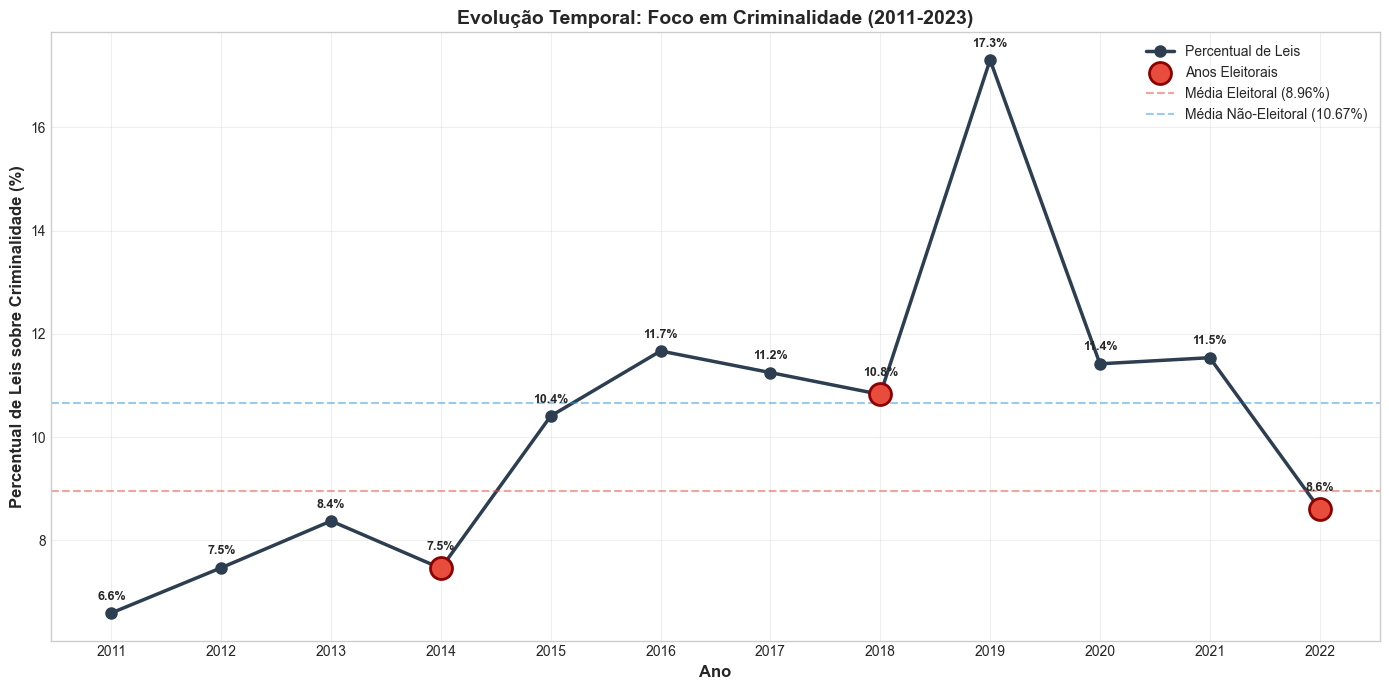

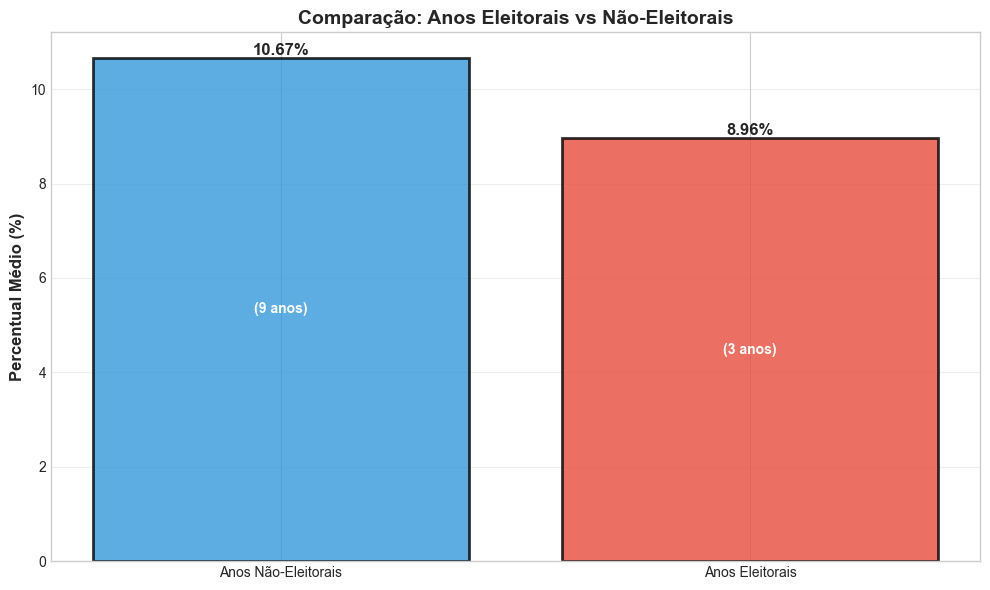

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from wordcloud import WordCloud
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# 1. DICIONÁRIOS TEMÁTICOS

DICIONARIO_CORE = {
    'crimes_violencia': ['crime', 'criminal', 'criminoso', 'criminalidade', 'criminosa', 'violencia', 'violento', 'violenta', 'delito', 'infracão', 'ilicito', 'ilegal', 'vandalismo', 'depredacao', 'homicidio', 'assassinato', 'latrocinio', 'feminicidio', 'agressao', 'lesao corporal', 'violencia fisica'],
    'crime_organizado': ['organizacao criminosa', 'crime organizado', 'organizacoes criminosas', 'faccao', 'faccoes', 'quadrilha', 'bando', 'gang', 'gangue', 'milicia', 'milicias', 'miliciano', 'milicianos', 'trafico', 'traficante', 'traficantes', 'narcotraficante', 'cartel', 'mafia', 'comando vermelho', 'terceiro comando', 'tcp', 'cv', 'acp'],
    'armas': ['arma', 'armas', 'armamento', 'armamentos', 'arma de fogo', 'armas de fogo', 'fogo', 'fuzil', 'fuzis', 'pistola', 'revolver', 'rifle', 'municao', 'municoes', 'bala', 'balas', 'projetil', 'explosivo', 'explosivos', 'bomba', 'granada', 'porte de arma', 'posse de arma', 'comercio de armas', 'armamento belico', 'arsenal', 'desarmamento', 'desarmar'],
    'drogas': ['droga', 'drogas', 'entorpecente', 'entorpecentes', 'narcotico', 'narcoticos', 'substancia ilicita', 'cocaina', 'crack', 'maconha', 'cannabis', 'dependencia quimica', 'dependente quimico', 'combate as drogas', 'prevencao drogas'],
    'roubos_furtos': ['roubo', 'roubos', 'assalto', 'assaltos', 'furto', 'furtos', 'latrocinio', 'extorsao', 'sequestro', 'carcere privado', 'estelionato', 'fraude'],
    'seguranca_publica': ['seguranca publica', 'seguranca urbana', 'policia', 'policial', 'policiais', 'policiamento', 'militar', 'militares', 'pm', 'pmerj', 'policia civil', 'policia militar', 'delegacia', 'delegado', 'guarda municipal', 'guardas municipais', 'operacao policial', 'abordagem policial', 'forca nacional', 'exercito'],
    'prisional': ['presidio', 'presidios', 'prisao', 'prisoes', 'cadeia', 'cadeias', 'penitenciaria', 'penitenciarias', 'detento', 'detentos', 'preso', 'presos', 'carcere', 'carceraria', 'carcerario', 'reintegracao', 'ressocializacao', 'regime fechado', 'regime semiaberto'],
    'vigilancia_monitoramento': ['camera', 'cameras', 'cftv', 'videomonitoramento', 'vigilancia', 'monitoramento', 'alarme', 'alarmes', 'cerca eletrica', 'seguranca eletronica', 'rastreamento', 'gps'],
    'vitimas_protecao_core': ['violencia domestica', 'violencia mulher', 'abuso sexual', 'estupro', 'assedio sexual'],
    'justica_punicao_core': ['pena', 'penas', 'punir', 'condenacao', 'condena', 'sentenca', 'reclusao', 'detencao'],
}

DICIONARIO_CONTEXTUAL = {
    'prevencao_combate': ['prevencao', 'prevenir', 'preventivo', 'combate', 'combater', 'enfrentamento', 'reducao criminalidade', 'controle criminalidade', 'ostensivo', 'repressao', 'reprimir'],
    'justica_punicao_contextual': ['punicao', 'tribunal', 'judiciario', 'justica', 'penalidade', 'sancao', 'multa'],
    'vitimas_protecao_contextual': ['vitima', 'vitimas', 'vitimizacao', 'revitimizacao', 'protecao testemunha', 'protecao vitima', 'assedio'],
}

EXCLUSOES_HARD = [
    'crime de responsabilidade', 'crime eleitoral', 'crime ambiental',
    'abuso de autoridade', 'abuso do poder economico',
    'estatuto do servidor', 'plano de carreira', 'concurso publico',
    'orcamentarias', 'diretrizes orcamentarias',
    'assedio moral'
]

BOOSTERS = [
    'combate ao', 'combate a', 'prevencao ao', 'prevencao a',
    'enfrentamento ao', 'enfrentamento a', 'reducao do', 'reducao da'
]

PESOS_CATEGORIA = {
    'crime_organizado': 3.0, 'armas': 2.5, 'crimes_violencia': 2.0, 'drogas': 2.0,
    'roubos_furtos': 1.5, 'prisional': 1.5, 'seguranca_publica': 1.0,
    'vigilancia_monitoramento': 1.0, 'vitimas_protecao_core': 2.0, 'justica_punicao_core': 1.5,
    'prevencao_combate': 1.2, 'justica_punicao_contextual': 0.8, 'vitimas_protecao_contextual': 1.0,
}

# 2. FUNÇÕES DE PROCESSAMENTO

def normalizar_texto(texto):
    if pd.isna(texto): return ""
    texto = texto.lower()
    substituicoes = {
        'á': 'a', 'à': 'a', 'ã': 'a', 'â': 'a', 'ä': 'a',
        'é': 'e', 'è': 'e', 'ê': 'e', 'ë': 'e',
        'í': 'i', 'ì': 'i', 'î': 'i', 'ï': 'i',
        'ó': 'o', 'ò': 'o', 'õ': 'o', 'ô': 'o', 'ö': 'o',
        'ú': 'u', 'ù': 'u', 'û': 'u', 'ü': 'u',
        'ç': 'c', 'ñ': 'n'
    }
    for original, substituto in substituicoes.items():
        texto = texto.replace(original, substituto)
    return texto

def _buscar_termos_no_texto(texto_norm, dicionario, pesos):
    score = 0
    detalhes = defaultdict(list)
    palavras_encontradas = []

    for categoria, palavras in dicionario.items():
        peso = pesos.get(categoria, 1.0)
        
        for palavra in palavras:
            palavra_norm = normalizar_texto(palavra)
            
            if len(palavra_norm.split()) == 1:
                pattern = r'\b' + re.escape(palavra_norm) + r'\b'
            else:
                pattern = re.escape(palavra_norm)
            
            matches = len(re.findall(pattern, texto_norm))
            
            if matches > 0:
                score += matches * peso
                detalhes[categoria].append((palavra, matches))
                palavras_encontradas.append(palavra)
    
    return score, detalhes, palavras_encontradas

def analise_semantica_robusta(texto_norm, dic_core, dic_contextual, pesos, exclusoes, boosters):
    if not texto_norm:
        return 0, {}, False
    
    for termo_ex in exclusoes:
        termo_norm = normalizar_texto(termo_ex)
        if re.search(re.escape(termo_norm), texto_norm):
            return 0, {}, False

    score_core, detalhes_core, palavras_core = _buscar_termos_no_texto(
        texto_norm, dic_core, pesos
    )

    if score_core == 0:
        return 0, {}, False
    
    score_contextual, detalhes_contextual, palavras_contextual = _buscar_termos_no_texto(
        texto_norm, dic_contextual, pesos
    )

    score_total = score_core + score_contextual
    
    detalhes_total = defaultdict(list, detalhes_core)
    for categoria, items in detalhes_contextual.items():
        detalhes_total[categoria].extend(items)
        
    palavras_total = list(set(palavras_core + palavras_contextual))

    boost_factor = 1.0
    for termo_boost in boosters:
        termo_norm = normalizar_texto(termo_boost)
        if re.search(re.escape(termo_norm), texto_norm):
            boost_factor = 1.5
            break
            
    score_total *= boost_factor
    
    return score_total, dict(detalhes_total), palavras_total

# 3. CARREGAR E PROCESSAR DADOS

print("ANÁLISE TEMPORAL: LEGISLAÇÃO SOBRE CRIMINALIDADE E VIOLÊNCIA")
print("ALERJ - Leis Ordinárias 2011-2024")

df['data_proposicao'] = pd.to_datetime(df['data_proposicao'])
df['ano'] = df['data_proposicao'].dt.year

print(f"\Total de leis: {len(df)}")
print(f"Período: {df['ano'].min()} - {df['ano'].max()}")

# Processar análise semântica
print("\nProcessando análise semântica...")
df['texto_normalizado'] = df['ementa'].apply(normalizar_texto)

resultados = df['texto_normalizado'].apply(
    lambda x: analise_semantica_robusta(
        x, DICIONARIO_CORE, DICIONARIO_CONTEXTUAL, 
        PESOS_CATEGORIA, EXCLUSOES_HARD, BOOSTERS
    )
)
df['score_relevancia'], df['detalhes_categorias'], df['palavras_encontradas'] = zip(*resultados)
df['relevante'] = df['score_relevancia'] > 0

# 4. ANÁLISE POR LEGISLATURA

print("1. ANÁLISE POR LEGISLATURA")

analise_legislatura = df.groupby('legislacao').agg({
    'relevante': ['sum', 'count']
}).reset_index()
analise_legislatura.columns = ['legislacao', 'leis_criminalidade', 'total_leis']
analise_legislatura['percentual'] = (analise_legislatura['leis_criminalidade'] / analise_legislatura['total_leis']) * 100

# Ordenar cronologicamente
ordem_legislatura = ['Legislação 2011-2015', 'Legislação 2015-2019', 'Legislação 2019-2023']
analise_legislatura['legislacao'] = pd.Categorical(analise_legislatura['legislacao'], categories=ordem_legislatura, ordered=True)
analise_legislatura = analise_legislatura.sort_values('legislacao')

print("\nComparação por Legislatura:")

for _, row in analise_legislatura.iterrows():
    print(f"{row['legislacao']:25} | Total: {row['total_leis']:4} | Criminalidade: {row['leis_criminalidade']:3} | {row['percentual']:5.2f}%")

# Calcular variação percentual
var_2011_2015 = analise_legislatura[analise_legislatura['legislacao'] == 'Legislação 2011-2015']['percentual'].values[0]
var_2015_2019 = analise_legislatura[analise_legislatura['legislacao'] == 'Legislação 2015-2019']['percentual'].values[0]
var_2019_2023 = analise_legislatura[analise_legislatura['legislacao'] == 'Legislação 2019-2023']['percentual'].values[0]

print(f"\nVariação entre legislaturas:")
print(f"   2011-2015 → 2015-2019: {var_2015_2019 - var_2011_2015:+.2f} pontos percentuais")
print(f"   2015-2019 → 2019-2023: {var_2019_2023 - var_2015_2019:+.2f} pontos percentuais")
print(f"   2011-2015 → 2019-2023: {var_2019_2023 - var_2011_2015:+.2f} pontos percentuais")

# Visualização 1: Gráfico de barras por legislatura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Barras absolutas
x_pos = np.arange(len(analise_legislatura))
width = 0.35
bars1 = ax1.bar(x_pos - width/2, analise_legislatura['total_leis'], width, 
                label='Total de Leis', color='#95e1d3', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, analise_legislatura['leis_criminalidade'], width,
                label='Leis sobre Criminalidade', color='#ff6b6b', alpha=0.8)

ax1.set_xlabel('Legislatura', fontsize=12, fontweight='bold')
ax1.set_ylabel('Número de Leis', fontsize=12, fontweight='bold')
ax1.set_title('Volume de Leis por Legislatura', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([leg.split()[1] for leg in analise_legislatura['legislacao']], rotation=0)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Barras percentuais
bars3 = ax2.bar(range(len(analise_legislatura)), analise_legislatura['percentual'],
                color=['#3498db', '#e74c3c', '#f39c12'], alpha=0.8, edgecolor='black', linewidth=1.5)

ax2.set_xlabel('Legislatura', fontsize=12, fontweight='bold')
ax2.set_ylabel('Percentual (%)', fontsize=12, fontweight='bold')
ax2.set_title('Proporção de Leis sobre Criminalidade', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(analise_legislatura)))
ax2.set_xticklabels([leg.split()[1] for leg in analise_legislatura['legislacao']], rotation=0)
ax2.grid(axis='y', alpha=0.3)

for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# 5. ANÁLISE POR ANO (ANOS ELEITORAIS)

print("2. ANÁLISE POR ANO - FOCO EM ANOS ELEITORAIS")

analise_anual = df.groupby('ano').agg({
    'relevante': ['sum', 'count']
}).reset_index()
analise_anual.columns = ['ano', 'leis_criminalidade', 'total_leis']
analise_anual['percentual'] = (analise_anual['leis_criminalidade'] / analise_anual['total_leis']) * 100
analise_anual['ano_eleitoral'] = analise_anual['ano'].isin([2014, 2018, 2022])

print("\nAnálise Ano a Ano:")

for _, row in analise_anual.iterrows():
    marcador = "ELEITORAL" if row['ano_eleitoral'] else ""
    print(f"{int(row['ano'])} | Total: {row['total_leis']:4} | Criminalidade: {row['leis_criminalidade']:3} | {row['percentual']:5.2f}%{marcador}")

# Comparação: Anos eleitorais vs não-eleitorais
eleitorais = analise_anual[analise_anual['ano_eleitoral']]
nao_eleitorais = analise_anual[~analise_anual['ano_eleitoral']]

media_eleitoral = eleitorais['percentual'].mean()
media_nao_eleitoral = nao_eleitorais['percentual'].mean()

print(f"\nMédias:")
print(f" Anos eleitorais (2014, 2018, 2022): {media_eleitoral:.2f}%")
print(f" Anos não-eleitorais: {media_nao_eleitoral:.2f}%")
print(f" Diferença: {media_eleitoral - media_nao_eleitoral:+.2f} pontos percentuais")

# Visualização 2: Série temporal
fig, ax = plt.subplots(figsize=(14, 7))

# Linha principal
ax.plot(analise_anual['ano'], analise_anual['percentual'], 
        marker='o', linewidth=2.5, markersize=8, color='#2c3e50', label='Percentual de Leis')

# Destacar anos eleitorais
anos_eleitorais = analise_anual[analise_anual['ano_eleitoral']]
ax.scatter(anos_eleitorais['ano'], anos_eleitorais['percentual'], 
          color='#e74c3c', s=250, marker='o', zorder=5, 
          label='Anos Eleitorais', edgecolors='darkred', linewidths=2)

# Linhas de referência
ax.axhline(y=media_eleitoral, color='#e74c3c', linestyle='--', 
          alpha=0.5, label=f'Média Eleitoral ({media_eleitoral:.2f}%)')
ax.axhline(y=media_nao_eleitoral, color='#3498db', linestyle='--', 
          alpha=0.5, label=f'Média Não-Eleitoral ({media_nao_eleitoral:.2f}%)')

# Adicionar valores nos pontos
for _, row in analise_anual.iterrows():
    offset = 0.3 if row['ano_eleitoral'] else 0.2
    ax.text(row['ano'], row['percentual'] + offset, f"{row['percentual']:.1f}%",
           ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Ano', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentual de Leis sobre Criminalidade (%)', fontsize=12, fontweight='bold')
ax.set_title('Evolução Temporal: Foco em Criminalidade (2011-2023)', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(analise_anual['ano'])

plt.tight_layout()
plt.show()

# Visualização 3: Comparação anos eleitorais vs não-eleitorais
fig, ax = plt.subplots(figsize=(10, 6))

categorias = ['Anos Não-Eleitorais', 'Anos Eleitorais']
valores = [media_nao_eleitoral, media_eleitoral]
cores = ['#3498db', '#e74c3c']

bars = ax.bar(categorias, valores, color=cores, alpha=0.8, edgecolor='black', linewidth=2)

ax.set_ylabel('Percentual Médio (%)', fontsize=12, fontweight='bold')
ax.set_title('Comparação: Anos Eleitorais vs Não-Eleitorais', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, valores)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{val:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Adicionar quantidade de anos (usar o índice do bar em vez de inspecionar bar.get_x())
    idx_eleitorais = categorias.index("Anos Eleitorais")
    n_anos = len(eleitorais) if i == idx_eleitorais else len(nao_eleitorais)
    ax.text(bar.get_x() + bar.get_width()/2., height/2,
           f'({n_anos} anos)',
           ha='center', va='center', fontsize=10, color='white', fontweight='bold')

plt.tight_layout()
plt.show()